In [4]:
import numpy as np
import matplotlib.pyplot as plt

iter 9, loss 1.8984947314576224
iter 19, loss 1.8031783384598725
iter 29, loss 1.7135517565541092
iter 39, loss 1.6292649416831264
iter 49, loss 1.5499895293373231
iter 59, loss 1.4754174896452612
iter 69, loss 1.4052598659324693
iter 79, loss 1.3392455915676864
iter 89, loss 1.2771203802372915
iter 99, loss 1.218645685090292
iter 109, loss 1.1635977224791534
iter 119, loss 1.111766556287068
iter 129, loss 1.0629552390811503
iter 139, loss 1.0169790065644477
iter 149, loss 0.9736645220185994
iter 159, loss 0.9328491676343147
iter 169, loss 0.8943803798194307
iter 179, loss 0.8581150257549611
iter 189, loss 0.8239188186389669
iter 199, loss 0.7916657692169988
iter 209, loss 0.761237671346902
iter 219, loss 0.7325236194855752
iter 229, loss 0.7054195561163928
iter 239, loss 0.6798278472589763
iter 249, loss 0.6556568843183528
iter 259, loss 0.6328207106387195
iter 269, loss 0.6112386712285092
iter 279, loss 0.59083508421862
iter 289, loss 0.5715389327049418
iter 299, loss 0.5532835757100

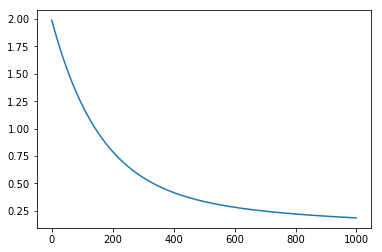

In [5]:
def load_data():
    # 导入房价数据
    datafile = '/home/aistudio/data/data99224/housing.data'
    data = np.fromfile(datafile, sep=' ')
    # 将原始数据Reshape 并且拆分成训练集和测试集
    data = data.reshape([-1, 14])
    offset = int(data.shape[0]*0.8)
    train_data = data[:offset]
    # 归一化处理
    maximums, minimums, avgs = train_data.max(axis=0), train_data.min(axis=0), train_data.sum(axis=0) / train_data.shape[0]
    for i in range(14):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])
    train_data = data[:offset]
    test_data = data[offset:]
    return train_data, test_data


class Network(object):
    def __init__(self, num_of_weight):
        # 随机产生w初始值
        np.random.seed(0)
        # randn函数返回一组样本，具有标准正态分布，维度为[num_of_weight, 1]
        self.w = np.random.randn(num_of_weight, 1)
        self.b = 0.

    def forword(self, x):   # 前向计算
        z = np.dot(x, self.w) + self.b
        return z

    def loss(self, z, y):   # loss计算
        error = z - y
        cost = error * error
        cost = np.mean(cost)
        return cost

    def gradient(self, x, y):   # 计算梯度
        z = self.forword(x)
        gradient_w = np.mean((z - y)*x, axis=0)
        gradient_w = gradient_w[:, np.newaxis]  # [13,] -> [13, 1]
        gradient_b = np.mean((z - y), axis=0)
        return gradient_w, gradient_b

    def update(self, gradient_w, gradient_b, eta=0.01):     # 更新参数
        self.w = self.w - eta*gradient_w
        self.b = self.b - eta*gradient_b

    def train(self, x, y, iterations=100, eta=0.01):    # 训练代码
        losses = []
        for i in range(iterations):     # 训练多少轮
            z = self.forword(x)     # 前向计算
            loss = self.loss(z, y)  # 得到loss
            gradient_w, gradient_b = self.gradient(x, y)    # 计算梯度
            self.update(gradient_w, gradient_b, eta)    # 更新参数
            losses.append(loss)
            if (i+1) % 10 == 0:
                print('iter {}, loss {}'.format(i, loss))
        return losses


train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
net = Network(13)
# 开始训练
losses = net.train(x, y, iterations=1000, eta=0.01)
# 画出损失函数变化趋势
plot_x = np.arange(1000)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 